In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

In [3]:
torch.cuda.set_device(7)

### data

In [4]:
data_dict.keys()

dict_keys(['notl_brain_mr', 'notl_brain_ct', 'atlas_brain_mr', 'notl_ventricle_mr', 'notl_ventricle_ct', 'atlas_ventricle_mr'])

In [5]:
data_name = 'atlas_brain_mr'
data_name = 'notl_ventricle_mr' # choose non-atlas for transfer learning
f = data_dict[data_name]
train_paths, valid_paths, test1_paths, test2_paths = f()

In [6]:
train_ds = MRI_3D_Dataset(*train_paths)
valid_ds = MRI_3D_Dataset(*valid_paths)
test1_ds = MRI_3D_Dataset(*test1_paths) if test1_paths else None
test2_ds = MRI_3D_Dataset(*test2_paths) if test2_paths else None

In [7]:
bs = 1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)
test1_dl = DeviceDataLoader(DataLoader(test1_ds, batch_size=bs), device=data.device) if test1_ds else None
test2_dl = DeviceDataLoader(DataLoader(test2_ds, batch_size=bs), device=data.device) if test2_ds else None

### model

In [8]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)
gnorm_types = (nn.GroupNorm,)
insnorm_types = (nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)
norm_types = bn_types + gnorm_types + insnorm_types

def cond_init(m:nn.Module, init_func:LayerFunc):
    "Initialize the non-batchnorm layers of `m` with `init_func`."
    if (not isinstance(m, norm_types)) and (not isinstance(m, nn.PReLU)) and requires_grad(m): 
        init_default(m, init_func)

In [9]:
kaiming_init = True
model_name = 'baseline10'
f = experiment_model_dict[model_name]; m = f()
if kaiming_init: apply_leaf(m, partial(cond_init, init_func= nn.init.kaiming_normal_))

### NaN Callback

In [10]:
class BackwardHookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if hasattr(m, 'weight')]
        # needs to be is_forward=False, detach=False
        self.hooks = Hooks(self.modules, self.hook, is_forward=False, detach=False)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    
    def __del__(self): self.remove()

In [11]:
class CatchNanGrad(BackwardHookCallback):
    "Callback that catches a NaN gradient."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stop = False

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        if torch.any(torch.isnan(o[0])): 
            self.stop = True
            return (m, o)
    
    def on_backward_end(self, train, epoch, num_batch, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train and self.stop: 
            print (f'Epoch/Batch ({epoch}/{num_batch}): Invalid Grad, terminating training.')
            return {'stop_epoch': True, 'stop_training': True, 'skip_validate': True}

### backward hook

In [12]:
input = torch.randn(10).cuda()
target = torch.randn(1).cuda()
m1 = nn.Linear(10,10).cuda()
m2 = nn.Linear(10,1).cuda()

In [13]:
grads = []
acts = []

In [14]:
def hook_grad_fn(m,i,o): 
    print(m,i,o)
    grads.append(o)

def hook_act_fn(m,i,o): 
    print(m,i,o)
    acts.append(o)

In [15]:
m1.register_backward_hook(hook_grad_fn)
m2.register_backward_hook(hook_grad_fn)

m1.register_forward_hook(hook_act_fn)
m2.register_forward_hook(hook_act_fn)

In [16]:
out = m2(m1(input))

Linear(in_features=10, out_features=10, bias=True) (tensor([ 0.9387, -0.4827, -1.0887, -1.1454,  0.0623,  0.7531, -1.6193,  0.7378,
         0.1974, -1.0506], device='cuda:7'),) tensor([ 0.2942,  0.2710,  0.3910, -0.2322, -0.0555,  0.3180,  0.2395, -0.3145,
         0.1917, -0.4454], device='cuda:7', grad_fn=<AddBackward0>)
Linear(in_features=10, out_features=1, bias=True) (tensor([ 0.2942,  0.2710,  0.3910, -0.2322, -0.0555,  0.3180,  0.2395, -0.3145,
         0.1917, -0.4454], device='cuda:7', grad_fn=<AddBackward0>),) tensor([-0.1062], device='cuda:7', grad_fn=<AddBackward0>)


In [17]:
l = F.mse_loss(out, target)

In [18]:
l.backward()

Linear(in_features=10, out_features=1, bias=True) (tensor([3.7204], device='cuda:7'), tensor([3.7204], device='cuda:7')) (tensor([3.7204], device='cuda:7'),)
Linear(in_features=10, out_features=10, bias=True) (tensor([-0.3492, -1.0971,  1.0784, -0.1066, -0.8650,  1.1079,  0.8953,  0.5236,
        -0.2357,  0.9830], device='cuda:7'), tensor([-0.3492, -1.0971,  1.0784, -0.1066, -0.8650,  1.1079,  0.8953,  0.5236,
        -0.2357,  0.9830], device='cuda:7')) (tensor([-0.3492, -1.0971,  1.0784, -0.1066, -0.8650,  1.1079,  0.8953,  0.5236,
        -0.2357,  0.9830], device='cuda:7'),)


In [19]:
grads

[(tensor([3.7204], device='cuda:7'),),
 (tensor([-0.3492, -1.0971,  1.0784, -0.1066, -0.8650,  1.1079,  0.8953,  0.5236,
          -0.2357,  0.9830], device='cuda:7'),)]

In [20]:
acts

[tensor([ 0.2942,  0.2710,  0.3910, -0.2322, -0.0555,  0.3180,  0.2395, -0.3145,
          0.1917, -0.4454], device='cuda:7', grad_fn=<AddBackward0>),
 tensor([-0.1062], device='cuda:7', grad_fn=<AddBackward0>)]

### learn

In [10]:
# callbacks
MODEL_NAME='NOTL_Ventricle_MR_Baseline_10'
model_dir='notl_ventricle_mr_models'
early_stop=False
early_stop_cb = partial(EarlyStoppingCallback, monitor='dice_score', mode='max', patience=5)
save_model_cb = partial(SaveModelCallback, monitor='dice_score', mode='max', every='improvement', 
                        name=f'best_of_{MODEL_NAME}')
reduce_lr_cb = partial(ReduceLROnPlateauCallback, monitor='dice_score', mode='max', patience=0, factor=0.8)
csv_logger_cb = partial(CSVLogger, filename=f'logs/{model_dir}/{MODEL_NAME}')

if early_stop: 
    callback_fns = [early_stop_cb, save_model_cb, reduce_lr_cb, csv_logger_cb, CatchNanGrad]
else: 
    callback_fns = [save_model_cb, csv_logger_cb, CatchNanGrad, CatchNanActs, CatchNanParameters]
callbacks = [TerminateOnNaNCallback()]    

In [11]:
loss_func = 'dice'
learn = Learner(data=data, model=m, callbacks=callbacks, callback_fns=callback_fns, model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();

### lsuv

In [18]:
from ipyexperiments import IPyExperimentsPytorch

In [23]:
class ActStats:
    def __init__(self):
        pass
    def __call__(self, m, i, o):
        d = o.data
        self.mean,self.std = d.mean().item(),d.std().item()

def lsuv_module(m, model, xb):
    stats = ActStats()
    h = Hook(m, stats)

    if hasattr(m, 'bias'): 
        while model(xb) is not None and abs(stats.mean)  > 1e-3: m.bias -= stats.mean
    if hasattr(m, 'weight'):
        while model(xb) is not None and abs(stats.std-1) > 1e-3: m.weight.data /= stats.std

    h.remove()
    return stats.mean, stats.std

In [26]:
def lsuv_init(learn):
    "initialize model parameters with LSUV - https://arxiv.org/abs/1511.06422"
    with IPyExperimentsPytorch():
        modules = [m for m in flatten_model(learn.model) if hasattr(m, 'weight') and m.weight is not None]
        mdl = learn.model.cuda()
        xb, yb = learn.data.one_batch()
        for m in modules: print(lsuv_module(m, learn.model, xb.cuda()))
        for m in modules: 
            if hasattr(m, 'weight'): assert not torch.any(torch.isnan(m.weight))
            if hasattr(m, 'bias'): assert not torch.any(torch.isnan(m.bias))

In [ ]:
lsuv_init(learn)


*** Experiment started with the Pytorch backend
Device: ID 7, GeForce RTX 2080 Ti (10989 RAM)


*** Current state:
RAM:     Used     Free    Total        Util
CPU:    2,968  481,389  515,182 MB   0.58% 
GPU:      701   10,287   10,989 MB   6.39% 


(nan, 0.99951171875)
(nan, 0.9990234375)
(nan, 1.0009765625)
(nan, 0.99951171875)
(nan, 1.0009765625)
(nan, 1.0009765625)
(0.0, 1.0)
(nan, 1.0009765625)
(nan, 0.99951171875)
(nan, 1.0)
(nan, 1.0009765625)
(0.0, 0.99951171875)
(-0.0, 0.9990234375)
(nan, 1.0)
(nan, 1.0009765625)
(-0.0, 1.0)
(nan, 1.0009765625)
(0.0, 1.0)
(-0.0, 1.0009765625)
(-0.0, 1.0)
(-0.0, 1.0009765625)
(-0.0, 1.0009765625)
(-0.0, 0.9990234375)
(0.0, 0.9990234375)


### lamb

In [ ]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

### fit

In [ ]:
learn.fit_one_cycle(100, max_lr=5e-2)

epoch,train_loss,valid_loss,dice_score,time
0,0.969132,0.961316,0.043053,04:11
1,0.954806,0.940896,0.062313,04:11
2,0.931806,0.904532,0.112867,04:10


Better model found at epoch 0 with dice_score value: 0.04305286332964897.
Better model found at epoch 1 with dice_score value: 0.06231263652443886.
Better model found at epoch 2 with dice_score value: 0.11286657303571701.


### eval

In [24]:
[cb_fn for cb_fn in learn.callback_fns if cb_fn.func == Recorder]

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [18]:
fns = learn.callback_fns[1]

In [22]:
fns.func == Recorder

False

In [23]:
hasattr(learn.save_model_callback, 'best')

True

In [22]:
learn.save_model_callback.best

-inf

In [10]:
(learn.path/learn.model_dir).ls()

[PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_9.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_7.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_8.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_5.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_10.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_4.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_2.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_1.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_3.pth'),
 PosixPath('atlas_brain_mr_models/best_of_ATLAS_Brain_MR_Baseline_6.pth')]

In [223]:
learn.load('best_of_ATLAS_Brain_MR_Baseline_10');

In [224]:
learn.validate(learn.data.valid_dl)

[0.04120313, tensor(0.9592)]

In [225]:
learn.to_fp32();

In [226]:
if test1_dl: print(learn.validate(test1_dl))

[0.03833369, tensor(0.9621)]


In [227]:
if test2_dl: print(learn.validate(test2_dl))

[0.05513239, tensor(0.9454)]


### split

In [28]:
model = learn.model

In [29]:
c = dict(model.named_children())

In [30]:
print(len(c)); print(c.keys()); c

11
dict_keys(['down1', 'down2', 'down3', 'down4', 'middle', 'upblock1', 'upblock2', 'upblock3', 'seg2', 'seg3', 'seg_final'])


{'down1': DownBlock(
   (down): Sequential(
     (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
     (1): PReLU(num_parameters=1)
     (2): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     (3): Dropout3d(p=0.2)
   )
   (preact_res): PreActBlock(
     (c1): Sequential(
       (0): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (1): PReLU(num_parameters=1)
       (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
       (3): Dropout3d(p=0.2)
     )
     (c2): Sequential(
       (0): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (1): PReLU(num_parameters=1)
       (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
       (3): Dropout3d(p=0.2)
     )
   )
 ), 'down2': DownBlock(
   (down): Sequential(
     (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1,

In [31]:
def _baseline10_split(m:nn.Module): return (nn.ModuleList([m.down1, m.down2, m.down3, m.down4]),
                                           nn.ModuleList([m.middle, m.upblock1]),
                                           nn.ModuleList([m.upblock2, m.upblock3, m.seg2, m.seg3, m.seg_final])
                                          )

In [32]:
learn.split(_baseline10_split);

In [33]:
learn.layer_groups

[Sequential(
   (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
   (1): PReLU(num_parameters=1)
   (2): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
   (3): Dropout3d(p=0.2)
   (4): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
   (5): PReLU(num_parameters=1)
   (6): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
   (7): Dropout3d(p=0.2)
   (8): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
   (9): PReLU(num_parameters=1)
   (10): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
   (11): Dropout3d(p=0.2)
   (12): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
   (13): PReLU(num_parameters=1)
   (14): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
   (15): Dropout3d(p=0.2)
   (16): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine

In [202]:
learn.freeze_to(-4)

### epoch anneal


In [55]:
n_groups = 3
epochs = 1

In [56]:
def annealing_epochs(n_groups, epochs):
    for i in range(n_groups):
        yield int(max(1, annealing_cos(epochs,0,i/(n_groups))))

In [57]:
_epochs = annealing_epochs(n_groups, epochs)

In [61]:
next(_epochs)

StopIteration: 

### logs

In [64]:
# 

In [18]:
path = Path("logs/"); path.ls()

[PosixPath('logs/notl_brain_ct_models'),
 PosixPath('logs/notl_brain_mr_models'),
 PosixPath('logs/atlas_brain_mr_models')]

In [19]:
path = Path("logs/notl_brain_mr_models"); path.ls()

[PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_4.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_7.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_2.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_9.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_6.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_5.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_10.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_8.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_3.csv'),
 PosixPath('logs/notl_brain_mr_models/NOTL_Brain_MR_Baseline_1.csv')]

In [21]:
log_df = pd.read_csv(path/'NOTL_Brain_MR_Baseline_1.csv')

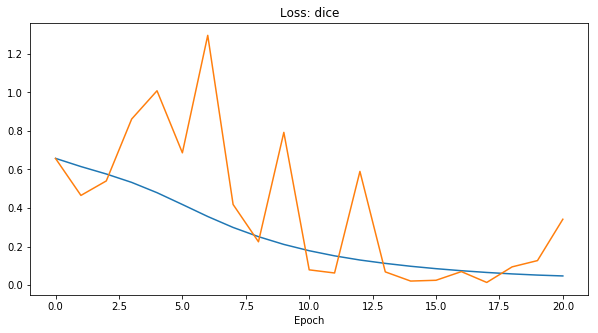

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title(f'Loss: {loss_func}')
ax.set_xlabel("Epoch")
ax.plot(log_df['train_loss'])
ax.plot(log_df['valid_loss']);

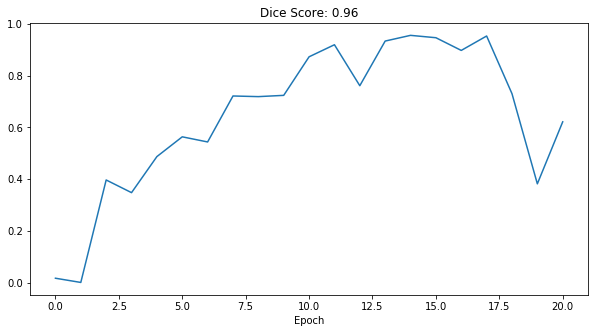

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title(f"Dice Score: {np.round(log_df['dice_score'].max(), 2)}")
ax.set_xlabel("Epoch")
plt.plot(log_df['dice_score']);

### Visualize

In [83]:
def to_int8(a): return a.astype(np.uint8)

In [65]:
data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=3)
data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=3)

In [125]:
train_fnames = data1.train_ds.img_fnames
valid_fnames = data1.valid_ds.img_fnames
test1_fnames = data1.test_ds.img_fnames
test2_fnames = data1.test_ds.img_fnames

In [128]:
len(train_fnames), len(valid_fnames), len(test1_fnames), len(test2_fnames)

(112, 15, 15, 15)

In [118]:
train_dl = data1.train_dl.new(shuffle=False)
valid_dl = data1.valid_dl.new(shuffle=False)
test1_dl = data1.test_dl.new(shuffle=False)
test2_dl = data2.test_dl.new(shuffle=False)

In [70]:
learn.to_fp16();

In [129]:
# training
images, preds, masks = get_img_pred_masks(learn, train_dl)

In [131]:
# validation
images, preds, masks = get_img_pred_masks(learn, valid_dl)

In [132]:
# test1
images, preds, masks = get_img_pred_masks(learn, test1_dl)

In [133]:
# test2
images, preds, masks = get_img_pred_masks(learn, test2_dl)

### Skull Stripping with Best Model

Use original brain masks for train and preds for valid and tests